In [1]:
import sys
import os

from IPython import display

import numpy as np
import scipy as sp

# our ROMs and FEM stuff
sys.path.append('..')
from fenics import XDMFFile, Mesh, Cell
from fenics import FunctionSpace, Function, Expression
import basix
from basix import ElementFamily, CellType, LagrangeVariant
from surrogates import NonlinearReducedBasisSurrogate as NRBS

from fenics import TestFunction, derivative, dot, inner, assemble, dx, grad

from scipy.integrate import solve_ivp

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# Configure plotting settings

In [2]:
import matplotlib
import matplotlib.pyplot as plt

fig_dir = "figures/"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True

# Read mesh and reference solution

In [3]:
nu = 0.001
A = 0.5
t_start = 0.0
t_final = 0.5
t_steps = 501
ts = np.linspace(t_start, t_final, t_steps)

file_name = "../output/burgers_1D/nu_" + str(nu) + "/FOM"
xdmffile = XDMFFile(file_name + ".xdmf")

mesh = Mesh()
xdmffile.read(mesh)
V = FunctionSpace(mesh, 'CG', 1)
X = V.tabulate_dof_coordinates()[:, 0]
u = Function(V)
N = V.dim()

u_ref = np.zeros((t_steps, N))
for i in range(t_steps):
    xdmffile.read_checkpoint(u, 'u', i)
    u_ref[i] = u.vector().get_local()

xdmffile.close()


# Plot the reference solution

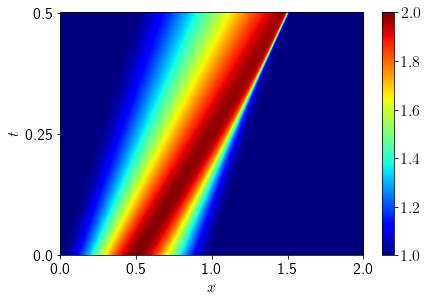

In [4]:
fig, ax = plt.subplots()
im = ax.imshow(u_ref, vmin=1, vmax=2, cmap='jet')
cb_ref = fig.colorbar(im)

ax.set_xlabel("$x$")
ax.set_xlim(N-1,0)
xtick_loc = np.linspace(0, N - 1, 5, dtype=int)
ax.set_xticks(xtick_loc)
ax.set_xticklabels(X[xtick_loc])

ax.set_ylabel("$t$")
ax.set_ylim(0,t_steps)
ax.set_yticks(np.linspace(0, t_steps - 1, 3))
ax.set_yticklabels(np.linspace(t_start, t_final, 3))

ax.set_aspect("auto")

plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_sol_ref.png")
plt.show()
plt.close()


# Solve POD

In [5]:
n = 20

Phi, svals, _ = sp.linalg.svd(u_ref.T, full_matrices=False)
Phi = Phi[:, :n]
svals =  svals[:n]

In [6]:
############################
# Function space
############################
V = FunctionSpace(mesh, "CG", 1)

############################
# Functions
############################
u = Function(V)
u_old = Function(V)
u0 = Function(V)
v = TestFunction(V)

############################
# Initial condition
############################
u0_expr = Expression(
    "x[0] < 1 ? 1+A*(sin(2*pi*x[0]-pi/2)+1) : 1", degree=1, A=A)
u0.interpolate(u0_expr)
u0_red = Phi.T.dot(u0.vector().get_local())

In [7]:
def assemble_reduced_form(form, Phi):
    mat = assemble(form).array()
    red = np.matmul(np.matmul(Phi.T, mat), Phi)
    return red

############################
# Weak form and Jacobian
# F = (dot(u - u_old, v) / Constant(dt) +
#     inner(nu * grad(u), grad(v)) + inner(u * u.dx(0), v)) * dx
############################
M_form = derivative(dot(u, v) * dx, u)
M_red = assemble_reduced_form(M_form, Phi)
M_red_inv = np.linalg.inv(M_red)

K_form = derivative(inner(nu * grad(u), grad(v)) * dx, u)
K_red = assemble_reduced_form(K_form, Phi)

def rhs_red(t, u_red):
    u.vector().set_local(Phi.dot(u_red))
    nl_form = inner(u.dx(0) * u, v) * dx
    nl_red = Phi.T.dot(assemble(nl_form).get_local())
    return -M_red_inv.dot(K_red.dot(u_red) + nl_red)


In [8]:
t_sequence = np.linspace(t_start, t_final, t_steps)
dt = (t_final - t_start) / t_steps

############################
# Solve ROM
############################
print("Solving the reduced order model")
u_red = solve_ivp(rhs_red, (t_start, t_final), u0_red,
                  t_eval=t_sequence, method='RK23')

u_approx = np.zeros((t_steps, N))
print("Mapping and writing ROM solution...")
for i in range(t_steps):
    u_approx[i] = Phi.dot(u_red.y[:, i])

Solving the reduced order model
Mapping and writing ROM solution...


# Compare the reference solution and the approximate solution using the surrogate

## First look at an early step where the solution is smooth

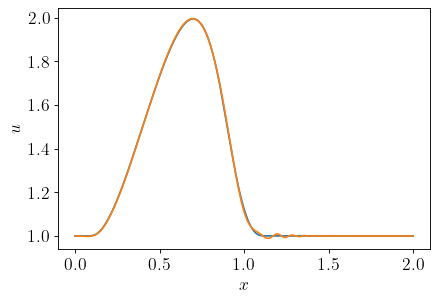

In [9]:
plt.figure(figsize=(6, 4), dpi=80)
u_peek = u_ref[100]
plt.plot(X, u_peek)
plt.plot(X, u_approx[100])
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.show()
plt.close()

## Then, look at a late step where the solution is sharp

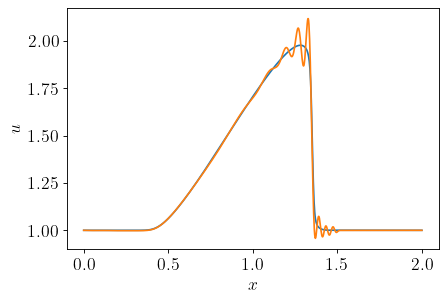

In [10]:
plt.figure(figsize=(6, 4), dpi=80)
u_peek = u_ref[400]
plt.plot(X, u_peek)
plt.plot(X,  u_approx[400])
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.show()
plt.close()

# Plot the ROM solution

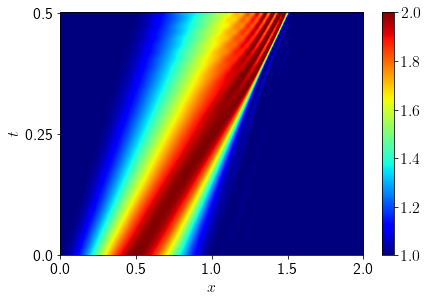

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(u_approx, vmin=1, vmax=2, cmap='jet')
cb_ref = fig.colorbar(im)

ax.set_xlabel("$x$")
ax.set_xlim(N-1, 0)
xtick_loc = np.linspace(0, N - 1, 5, dtype=int)
ax.set_xticks(xtick_loc)
ax.set_xticklabels(X[xtick_loc])

ax.set_ylabel("$t$")
ax.set_ylim(0, t_steps)
ax.set_yticks(np.linspace(0, t_steps - 1, 3))
ax.set_yticklabels(np.linspace(t_start, t_final, 3))

ax.set_aspect("auto")

plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_sol_n_" + str(n)+".png")
plt.show()
plt.close()


# ... and its error (relative to the reference solution)

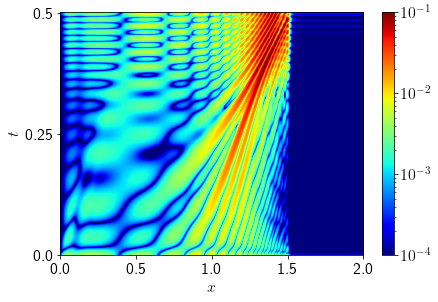

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(np.abs(u_approx - u_ref) / u_ref, cmap='jet', norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e-1))
cb_ref = fig.colorbar(im)

ax.set_xlabel("$x$")
ax.set_xlim(N-1, 0)
xtick_loc = np.linspace(0, N - 1, 5, dtype=int)
ax.set_xticks(xtick_loc)
ax.set_xticklabels(X[xtick_loc])

ax.set_ylabel("$t$")
ax.set_ylim(0, t_steps)
ax.set_yticks(np.linspace(0, t_steps - 1, 3))
ax.set_yticklabels(np.linspace(t_start, t_final, 3))

ax.set_aspect("auto")

plt.tight_layout(pad=0)
plt.savefig(fig_dir + "nu_" + str(nu) + "_err_n_" + str(n)+".png")
plt.show()
plt.close()


quantitative error

In [13]:
data_dir = "data/"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

np.savetxt(data_dir + "nu_" + str(nu) + "_sol_n_" + str(n)+".csv", np.asarray(u_approx))

In [14]:
# fig, ax = plt.subplots()
# ax.semilogy(t_sequence, np.linalg.norm(u_approx - u_ref, axis=1))

# ax.set_xlabel("$t$")
# ax.set_xlim(t_start, t_final)

# ax.set_ylabel("$e$")

# ax.set_aspect("auto")

# plt.tight_layout(pad=0)
# plt.savefig(fig_dir + "nu_" + str(nu) + "_transient_err_n_" + str(n)+".png")
# plt.show()
# plt.close()
